### EEGFormer for Synthetic EEG dataset
#### In this notebook, the full pipeline is: load data -> concat data -> preprocessing data -> load model -> train model -> save .pkl and plots
##### EEGFormer on synthetic: 
1. Synthetic data is generated by Gaussion Process Joint Model (https://www.pnas.org/doi/10.1073/pnas.1912342117), I defined 3 different latent dynamics to generate 3 different eeg data(for each the shape is (151,27)), and assign labels to them.
2. Keep the model.py almost same as https://github.com/FENRlR/EEGformer, and train the synthetic data to do the 3-way classification task.
3. Perhaps because synthetic data is strongly separable across windows, the accuracy quickly approaches 1.

In [1]:
import os
import sys
from pathlib import Path
from math import gcd

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split, WeightedRandomSampler
import mne
from scipy import signal
from sklearn.preprocessing import StandardScaler

In [2]:
cwd = Path.cwd()
root = cwd.parent.parent
data_dir = root / "data" / "synthetic_eeg"

f1 = data_dir / "neural_data_label1_1.npy"
f2 = data_dir / "neural_data_label2_1.npy"
f3 = data_dir / "neural_data_label3_1.npy"

x1 = np.load(f1)  # (151,27)
x2 = np.load(f2)  # (151,27)
x3 = np.load(f3)  # (151,27)

X = np.concatenate([x1, x2, x3], axis=0)  # (453,27)
print("X shape:", X.shape)

y_point = np.concatenate([
    np.zeros(len(x1), dtype=int),         # label 0
    np.ones(len(x2), dtype=int),          # label 1
    np.full(len(x3), 2, dtype=int)        # label 2
])
print("y_point shape:", y_point.shape)

X shape: (453, 27)
y_point shape: (453,)


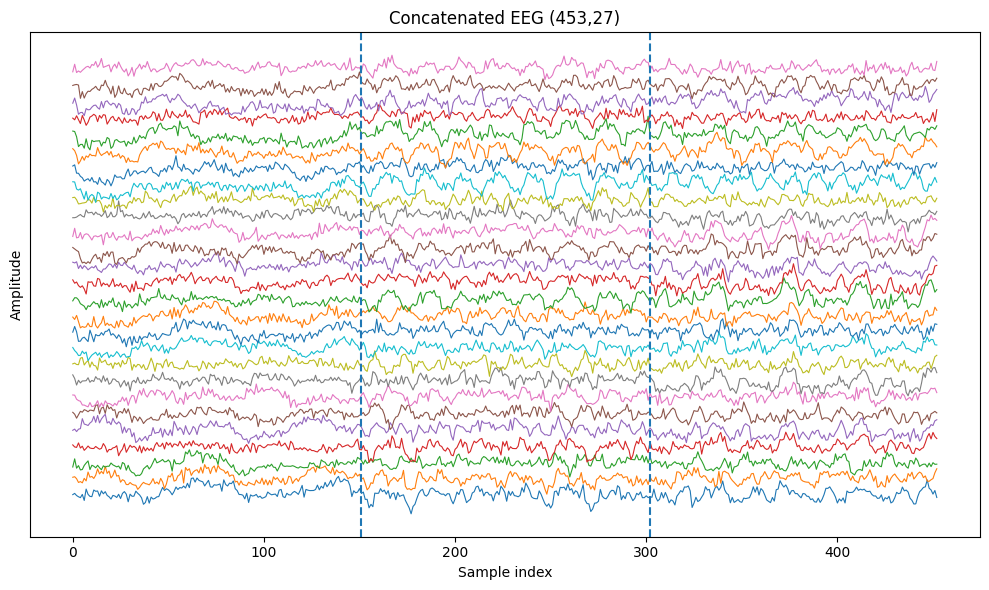

In [ ]:
import matplotlib.pyplot as plt

t = np.arange(X.shape[0])
plt.figure(figsize=(10, 6))

offset = 3.0 * np.std(X)
for ch in range(X.shape[1]):
    plt.plot(t, X[:, ch] + ch * offset, linewidth=0.8)

plt.axvline(151, linestyle="--")
plt.axvline(302, linestyle="--")

plt.xlabel("Sample index")
plt.ylabel("Amplitude")
plt.title("Concatenated EEG (453,27)")
plt.yticks([])
plt.tight_layout()
plt.show()

In [4]:
class WindowEEGDataset(Dataset):
    def __init__(self, X, y_point, win_len=120, stride=5):
        self.X = X.astype(np.float32)
        self.y = y_point.astype(np.int64)
        self.win_len = win_len
        self.stride = stride

        change_idx = np.where(self.y[1:] != self.y[:-1])[0] + 1
        boundaries = [0] + change_idx.tolist() + [len(self.y)]
        blocks = [(boundaries[i], boundaries[i+1]) for i in range(len(boundaries)-1)]

        self.samples = []
        for (s, e) in blocks:
            label = int(self.y[s])
            for start in range(s, e - win_len + 1, stride):
                self.samples.append((start, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        start, label = self.samples[idx]
        x_win = self.X[start:start+self.win_len, :]  # (win_len, C)
        return torch.from_numpy(x_win), torch.tensor(label, dtype=torch.long)

In [5]:
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import Subset

scaler = StandardScaler()
X_std = scaler.fit_transform(X).astype(np.float32)

win_len = 120
stride = 1

full_ds = WindowEEGDataset(X_std, y_point, win_len=win_len, stride=stride)
labels = np.array([full_ds[i][1].item() for i in range(len(full_ds))])

# Ensure that each class is included in train/test/val
sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.30, random_state=0)
train_idx, temp_idx = next(sss1.split(np.zeros(len(labels)), labels))

labels_temp = labels[temp_idx]
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.50, random_state=0)
val_rel, test_rel = next(sss2.split(np.zeros(len(labels_temp)), labels_temp))

val_idx = temp_idx[val_rel]
test_idx = temp_idx[test_rel]

train_ds = Subset(full_ds, train_idx)
val_ds   = Subset(full_ds, val_idx)
test_ds  = Subset(full_ds, test_idx)

print("Train:", np.bincount(labels[train_idx]))
print("Val  :", np.bincount(labels[val_idx]))
print("Test :", np.bincount(labels[test_idx]))

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=16, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=16, shuffle=False)

print("num windows:", len(full_ds))
print("train/val/test:", len(train_ds), len(val_ds), len(test_ds))

Train: [22 22 23]
Val  : [5 5 4]
Test : [5 5 5]
num windows: 96
train/val/test: 67 14 15


In [6]:
import sys
from pathlib import Path

project_root = Path.cwd().parents[1]
sys.path.append(str(project_root))

from EEGformer.models import EEGformer

In [ ]:
import torch
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dummy_input = torch.zeros(win_len, 27).to(device)

model = EEGformer(
    input=dummy_input,
    num_cls=3,
    input_channels=27,
    kernel_size=10,      # => T' = 120 - 3*(10-1) = 93
    num_blocks=2,
    num_heads_RTM=3,     # 93 % 3 == 0
    num_heads_STM=3,     # 93 % 3 == 0
    num_heads_TTM=4,     # (28*121)=3388 % 4 == 0
    num_submatrices=3,   # 93 % 3 == 0
    CF_second=8,
    dtype=torch.float32
).to(device)

In [8]:
import json

out_dir = Path.cwd() / "eegformer_outputs"
out_dir.mkdir(parents=True, exist_ok=True)

def save_checkpoint(model, path):
    torch.save(model.state_dict(), str(path))

def save_history(history, path_json):
    with open(path_json, "w", encoding="utf-8") as f:
        json.dump(history, f, indent=2)

def plot_history(history, path_png):
    epochs = history["epoch"]
    plt.figure()
    plt.plot(epochs, history["train_loss"], label="train_loss")
    plt.plot(epochs, history["val_loss"], label="val_loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.savefig(path_png, dpi=200)
    plt.close()

    path_png_acc = Path(str(path_png).replace("loss", "acc"))
    plt.figure()
    plt.plot(epochs, history["train_acc"], label="train_acc")
    plt.plot(epochs, history["val_acc"], label="val_acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.savefig(path_png_acc, dpi=200)
    plt.close()

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.0)
max_grad_norm = 1.0

def forward_batch(model, xb):
    """
    xb: (B, T, C)
    logits: (B, num_cls)
    Adapting to the current EEGformer's single-sample forward iteration
    """
    outs = []
    for i in range(xb.shape[0]):
        out = model(xb[i])              # logits
        if out.dim() == 2:
            out = out.squeeze(0)        # (num_cls,)
        outs.append(out)
    return torch.stack(outs, dim=0)     # (B, num_cls)

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    total_loss, total_correct, total = 0.0, 0, 0

    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        logits = forward_batch(model, xb)    # (B,3)
        loss = loss_fn(logits, yb)

        pred = logits.argmax(dim=1)
        total_loss += loss.item() * xb.size(0)
        total_correct += (pred == yb).sum().item()
        total += xb.size(0)

    return total_loss / total, total_correct / total

def train(model, train_loader, val_loader, epochs=30, save_best=True):
    history = {
        "epoch": [],
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": [],
    }

    best_val_acc = -1.0
    best_path = out_dir / "eegformer_best.pt"

    for ep in range(1, epochs + 1):
        model.train()
        total_loss, total_correct, total = 0.0, 0, 0

        for step, (xb, yb) in enumerate(train_loader):
            xb, yb = xb.to(device), yb.to(device)

            optimizer.zero_grad(set_to_none=True)
            logits = forward_batch(model, xb)
            loss = loss_fn(logits, yb)
            loss.backward()

            # DEBUG 
            if ep == 1 and step == 0:
                g = model.cnndecoder.fc.weight.grad
                print("DEBUG grad is None?", g is None,
                      "| grad abs mean:", None if g is None else g.abs().mean().item())
                with torch.no_grad():
                    print("DEBUG logits mean/std:", logits.mean().item(), logits.std().item())

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            optimizer.step()

            pred = logits.argmax(dim=1)
            total_loss += loss.item() * xb.size(0)
            total_correct += (pred == yb).sum().item()
            total += xb.size(0)

        train_loss = total_loss / total
        train_acc = total_correct / total
        val_loss, val_acc = evaluate(model, val_loader)

        history["epoch"].append(ep)
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        if save_best and val_acc > best_val_acc:
            best_val_acc = val_acc
            save_checkpoint(model, best_path)

        print(f"Epoch {ep:03d} | train loss {train_loss:.4f} acc {train_acc:.3f} "
              f"| val loss {val_loss:.4f} acc {val_acc:.3f}")

    last_path = out_dir / "eegformer_last.pt"
    save_checkpoint(model, last_path)
    hist_path = out_dir / "train_history.json"
    save_history(history, hist_path)
    plot_history(history, out_dir / "train_curve_loss.png")

    print(f"\nSaved last checkpoint to: {last_path}")
    if save_best:
        print(f"Saved best checkpoint to: {best_path} (best val acc = {best_val_acc:.3f})")
    print(f"Saved training history to: {hist_path}")
    print(f"Saved curves to: {out_dir / 'train_curve_loss.png'} and train_curve_acc.png")

    return history

train(model, train_loader, val_loader, epochs=30)

test_loss, test_acc = evaluate(model, test_loader)
print(f"TEST | loss {test_loss:.4f} acc {test_acc:.3f}")


DEBUG grad is None? False | grad abs mean: 0.012925481423735619
DEBUG logits mean/std: -0.013562498614192009 0.23298683762550354
Epoch 001 | train loss 1.1155 acc 0.328 | val loss 1.0759 acc 0.357
Epoch 002 | train loss 0.9893 acc 0.522 | val loss 0.8466 acc 0.714
Epoch 003 | train loss 0.7438 acc 0.925 | val loss 0.5859 acc 1.000
Epoch 004 | train loss 0.4692 acc 1.000 | val loss 0.3458 acc 1.000
Epoch 005 | train loss 0.2497 acc 1.000 | val loss 0.1531 acc 1.000
Epoch 006 | train loss 0.1239 acc 1.000 | val loss 0.1450 acc 1.000
Epoch 007 | train loss 0.0765 acc 1.000 | val loss 0.0386 acc 1.000
Epoch 008 | train loss 0.0235 acc 1.000 | val loss 0.0134 acc 1.000
Epoch 009 | train loss 0.0086 acc 1.000 | val loss 0.0056 acc 1.000
Epoch 010 | train loss 0.0041 acc 1.000 | val loss 0.0030 acc 1.000
Epoch 011 | train loss 0.0023 acc 1.000 | val loss 0.0018 acc 1.000
Epoch 012 | train loss 0.0015 acc 1.000 | val loss 0.0012 acc 1.000
Epoch 013 | train loss 0.0010 acc 1.000 | val loss 0.00